05 CNNの実装
===========

* `Convolution`レイヤと`Pooling`レイヤを実装したので、それらのレイヤを組み合わせて、手書き数字認識を行うCNNを組み立てる

    * ここでは、以下の図のようなCNNを実装する
    
    * ネットワークの構成は、「Convolution-ReLU-Pooling-Affine-ReLU-Affine-Softmax」という流れ
    
    * これを、`SimpleConvNet`という名前のクラスで実装する
    
![単純なCNNのネットワーク構成](./images/単純なCNNのネットワーク構成.png)

* `SimpleConvNet`の初期化(`__init__`)を見てみる

### 引数

* `input_dim`：入力データの(チャンネル、高さ、幅)の次元

* `conf_param`：畳み込み層のハイパーパラメータ(ディクショナリ)

    * `filter_num`：フィルターの数
    
    * `filter_size`：フィルターのサイズ
    
    * `sride`：ストライド
    
    * `pad`：パディング
    
* `hidden_size`：隠れ層(全結合)のニューロンの数

* `output_size`：出力層(全結合)のニューロンの数

* `weight_init_std`：初期化の際の重みの標準偏差

* ここで、畳み込み層のハイパーパラメータは、`conv_param`という名前のディクショナリとして与えられているものとする

    * 例)`{'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1}`のように、必要なハイパーパラメータの値が格納されていることを想定する

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
%matplotlib inline

In [2]:
class SimpleConvNet:
    """単純なConvNet
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.299173020986537
=== epoch:1, train acc:0.168, test acc:0.153 ===
train loss:2.295359368712647
train loss:2.294160875943675
train loss:2.2862768887980054
train loss:2.2696728485356594
train loss:2.262964490194248
train loss:2.250721321673919
train loss:2.2338667452047063
train loss:2.1843182478501864
train loss:2.1846533014264944
train loss:2.1569703211188975
train loss:2.112127787724697
train loss:2.0598707783674457
train loss:1.9856654656720485
train loss:1.9008510504050813
train loss:1.9193422116904415
train loss:1.812129313133479
train loss:1.654639799313833
train loss:1.5986331510319374
train loss:1.5174145961819594
train loss:1.5184168230424442
train loss:1.394810589053508
train loss:1.2494317212936612
train loss:1.2676714171229932
train loss:1.1435318434943245
train loss:1.1166211058507949
train loss:1.0079277491600953
train loss:0.9226949765845376
train loss:0.9223765086061855
train loss:0.8701771582004022
train loss:0.9728024839590776
train loss:0.7763414166668938


train loss:0.34490471841497955
train loss:0.24045872575910276
train loss:0.30028058735809565
train loss:0.28020914593902274
train loss:0.2879648404794596
train loss:0.3198391149996858
train loss:0.15343326949276123
train loss:0.18862002969157332
train loss:0.2733861714799022
train loss:0.21344334340104226
train loss:0.29374430747909125
train loss:0.29210917582040263
train loss:0.2678900256093986
train loss:0.2776779021513296
train loss:0.1251207347003551
train loss:0.18053790080522902
train loss:0.20713294847538996
train loss:0.25535515577200285
train loss:0.19339127275006956
train loss:0.2509077227512138
train loss:0.1774365085986678
train loss:0.26179630050528646
train loss:0.30523107090257434
train loss:0.13367421309839675
train loss:0.12242905960723097
train loss:0.19998154115250988
train loss:0.22356494996311788
train loss:0.26969085374603746
train loss:0.21569768619215648
train loss:0.21208681201600496
train loss:0.1824436829032528
train loss:0.1545972423353064
train loss:0.18451

train loss:0.08604893637039636
train loss:0.2515504889513131
train loss:0.03622230310450286
train loss:0.16017143931619734
train loss:0.20069531610378769
train loss:0.20513127607696366
train loss:0.11485911136682207
train loss:0.11100260309327488
train loss:0.07599576042850582
train loss:0.06668175037771397
train loss:0.14224460178071155
train loss:0.13272066626771156
train loss:0.09803430728588883
train loss:0.15994664870450925
train loss:0.0639869934065682
train loss:0.14366708812071752
train loss:0.058445008917690625
train loss:0.15362594251937237
train loss:0.20746027847674692
train loss:0.11938918245054023
train loss:0.10088998806141275
train loss:0.06307319210909398
train loss:0.08116417765117707
train loss:0.15939343136118608
train loss:0.1319868897874612
train loss:0.14799496999014364
train loss:0.13926069376120273
train loss:0.08969661399980489
train loss:0.09920281278313933
train loss:0.24561652759314176
train loss:0.062243610091848
train loss:0.11499607362794696
train loss:0

train loss:0.09187453454496712
train loss:0.11396848804972164
train loss:0.10938219806929712
train loss:0.08256392102036711
train loss:0.04364057250185703
train loss:0.17518038122396265
train loss:0.08191825856061294
train loss:0.08142318707565228
train loss:0.047657302167663236
train loss:0.03445628844043258
train loss:0.05109628750155254
train loss:0.10661047054770385
train loss:0.04681237394197563
train loss:0.05924679771274519
train loss:0.10210234644969644
train loss:0.03215583987388532
train loss:0.022176999893028678
train loss:0.08272540702907434
train loss:0.1759570458537321
train loss:0.06623463422195569
train loss:0.12490899179571983
train loss:0.16085445872762377
train loss:0.15142946179607303
train loss:0.0981529015375568
train loss:0.03577582031341216
train loss:0.03866278008243848
train loss:0.12138590072018962
train loss:0.14001659932203359
train loss:0.07177200910046512
train loss:0.12269382750060226
train loss:0.07126303114545791
train loss:0.0916833137895165
train los

train loss:0.06657995965665846
train loss:0.023085950056393325
train loss:0.15718590668612495
train loss:0.024941023156122788
train loss:0.053350327376421695
train loss:0.02491020708357121
train loss:0.10608822955881525
train loss:0.11816199197761923
train loss:0.09418140686970973
train loss:0.02380363290910741
train loss:0.06200629593251918
train loss:0.05531598773532392
train loss:0.11865592299027825
train loss:0.05361303580656314
train loss:0.04558550696304676
train loss:0.0458620730248711
train loss:0.04055045413042633
train loss:0.06422709532346388
train loss:0.04669478994058356
train loss:0.06240066063826616
train loss:0.042460799488475594
train loss:0.04286515689206415
train loss:0.03528812268721136
train loss:0.0679821963899772
train loss:0.054031641818103646
train loss:0.1045557915146414
train loss:0.12264302341105235
train loss:0.05966352968394517
train loss:0.03537135681302415
train loss:0.08282172054685852
train loss:0.04761422421865032
train loss:0.016877296732323684
train

train loss:0.07908260215094436
train loss:0.12450269377781113
train loss:0.08486228757746078
train loss:0.054705439735724115
train loss:0.02225365596400873
train loss:0.05324861903605405
train loss:0.07685730837335354
train loss:0.03393246010058255
train loss:0.07709051928705657
train loss:0.09943106367453161
train loss:0.06693042999749287
train loss:0.08888456065291603
train loss:0.019887415117726924
train loss:0.04001377866422663
train loss:0.11327936919872406
train loss:0.038792926737991784
train loss:0.08581524680213524
train loss:0.045634872707511036
train loss:0.008850353431962527
train loss:0.09243295016379172
train loss:0.04243079209383047
train loss:0.03297487106473442
train loss:0.013602502909881546
train loss:0.033910399937288054
train loss:0.02322838367821054
train loss:0.03312234307705668
train loss:0.026022093657321506
train loss:0.07311829974858072
train loss:0.04896417569862892
train loss:0.015221679628404039
train loss:0.03261436386591725
train loss:0.03952586345443925

train loss:0.08319983845187062
train loss:0.015346139195342931
train loss:0.024338916214187198
train loss:0.03158079620263644
train loss:0.03999275958105012
train loss:0.013453150435939334
train loss:0.03477040169777614
train loss:0.08420245150336403
train loss:0.04586071710903229
train loss:0.04328872828258589
train loss:0.005727799294046485
train loss:0.10092005709371225
train loss:0.04503280506640417
train loss:0.04902644108986978
train loss:0.08298755036538827
train loss:0.03102575537014658
train loss:0.07781692921625233
train loss:0.009161948796855099
train loss:0.03594646635846808
train loss:0.03337111135315657
train loss:0.028997166698523594
train loss:0.06668716899034834
train loss:0.05583872546835001
train loss:0.02198926926725239
train loss:0.015765411182524308
train loss:0.01886212679661382
train loss:0.03277061367106632
train loss:0.026265571761844422
train loss:0.10475221218989522
train loss:0.06296215017916935
train loss:0.09216821600847844
train loss:0.01411608984378707


train loss:0.026866517751431923
train loss:0.02143087852530669
train loss:0.10626818619593838
train loss:0.0175885232775533
train loss:0.05262742247781583
train loss:0.006794546749017431
train loss:0.050999562189726684
train loss:0.027597324876517355
train loss:0.03859188225835789
train loss:0.03972708582188619
train loss:0.030801371787808052
train loss:0.0453340621723228
train loss:0.01682232378430413
train loss:0.016077228732045513
train loss:0.015454150265240829
train loss:0.057342014131062644
train loss:0.08200484520712863
train loss:0.050268158118158796
train loss:0.07588359039882718
train loss:0.05071219113021088
train loss:0.04966173233513246
train loss:0.015426229233373938
train loss:0.05643883350918534
train loss:0.045256777834181514
train loss:0.04518952944199867
train loss:0.05738111503215913
train loss:0.05283590417055179
train loss:0.052492232387548216
train loss:0.07866925734996111
train loss:0.008061385149314643
train loss:0.011930392897365598
train loss:0.02974937226587

train loss:0.10870683651690351
train loss:0.01806536502684354
train loss:0.0230832860583455
train loss:0.05711271914907092
train loss:0.030641955365821403
train loss:0.008688115284422461
train loss:0.06966940523484313
train loss:0.02940200206089099
train loss:0.019902363596353213
train loss:0.0345588325852729
train loss:0.019366494298698064
train loss:0.019073401373628784
train loss:0.03422115339183369
train loss:0.021344189451759324
train loss:0.020449783611086344
train loss:0.014730620448095602
train loss:0.06762385520846463
train loss:0.034983514753106675
train loss:0.01132558374250974
train loss:0.023315211709875452
train loss:0.0046559719609355074
train loss:0.0051127035152301725
train loss:0.024253325946545518
train loss:0.04255255520288947
train loss:0.06864142418114232
train loss:0.010594936349599977
train loss:0.004053993248808753
train loss:0.020312537620718166
train loss:0.019061013964342108
train loss:0.043685552851975284
train loss:0.011404927231652831
train loss:0.0430956

train loss:0.015106371761023325
train loss:0.029642716338334204
train loss:0.005034319299126166
train loss:0.026096802402102753
train loss:0.04529158285837407
train loss:0.01423503811740018
train loss:0.020374001219024503
train loss:0.06170876060192084
train loss:0.016198868446177638
train loss:0.009869200039700427
train loss:0.03235993515544244
train loss:0.011562388826216526
train loss:0.047383245941683506
train loss:0.019449633444366524
train loss:0.053345968932187994
train loss:0.01856666278741693
train loss:0.006392919971516883
train loss:0.015447227595691646
train loss:0.01751788052605101
train loss:0.019285468750063556
train loss:0.08011464433442321
train loss:0.009415003762416914
train loss:0.023211908123254247
train loss:0.009805406166838813
train loss:0.05265295442166729
train loss:0.015127708668357314
train loss:0.010530933041454917
train loss:0.05516698946261022
=== epoch:5, train acc:0.985, test acc:0.983 ===
train loss:0.01712589080429971
train loss:0.04428691947717782
tr

train loss:0.012475389501552803
train loss:0.008683275693394749
train loss:0.022500113672632716
train loss:0.032786258411289515
train loss:0.007728171052139715
train loss:0.01720492893598937
train loss:0.008734823064630881
train loss:0.005256229944106246
train loss:0.014839827978769543
train loss:0.024956530947958605
train loss:0.01816807212116844
train loss:0.03990236230969697
train loss:0.020639682064055035
train loss:0.02600173899120752
train loss:0.01596764711455782
train loss:0.011916346136148625
train loss:0.031111144957914654
train loss:0.024760660767698624
train loss:0.026807802941295363
train loss:0.0028907626878007854
train loss:0.024064333231993692
train loss:0.04107453094867061
train loss:0.06408046637825934
train loss:0.046107089334437884
train loss:0.012705454180220925
train loss:0.04122655977009001
train loss:0.022739637208189962
train loss:0.020546059452452567
train loss:0.009744261178117046
train loss:0.02831313036970254
train loss:0.012687221230632033
train loss:0.012

train loss:0.05022793308423197
train loss:0.006574668926474937
train loss:0.04350268418414667
train loss:0.015579565714004831
train loss:0.01036781160225662
train loss:0.044534857705857495
train loss:0.01974587740204636
train loss:0.04003145616279765
train loss:0.0098216425321849
train loss:0.006477594788225269
train loss:0.01106325418175655
train loss:0.019678757784585756
train loss:0.07268024469779416
train loss:0.06865182314339038
train loss:0.0347627974989975
train loss:0.02769618791177049
train loss:0.0243292390859834
train loss:0.01788971042508362
train loss:0.01972532469624768
train loss:0.04317710491432087
train loss:0.022039652454306093
train loss:0.006527254866808857
train loss:0.01278771567246268
train loss:0.07488829513571087
train loss:0.03825314045497987
train loss:0.013272935350568345
train loss:0.024949968706470264
train loss:0.032261077516878546
train loss:0.024547822017480306
train loss:0.010221103657151452
train loss:0.02205139951706305
train loss:0.00711909529185805

train loss:0.011085477801813235
train loss:0.009879034356019499
train loss:0.017689766632110335
train loss:0.030772850023727396
train loss:0.02768838284156737
train loss:0.07183481842746875
train loss:0.015437269443065853
train loss:0.033335134032622504
train loss:0.004717107457912526
train loss:0.007416036944460445
train loss:0.038603552324037
train loss:0.09059644102074316
train loss:0.04423132335212271
train loss:0.028657016959780592
train loss:0.0440310432181995
train loss:0.012824638421908232
train loss:0.01511386468578801
train loss:0.0065478092484012925
train loss:0.10669579164473865
train loss:0.04751330875022629
train loss:0.024771517514930258
train loss:0.00957590776938025
train loss:0.016854483351055768
train loss:0.0032513125133723144
train loss:0.08079750855526756
train loss:0.03699344662745408
train loss:0.014636966701327478
train loss:0.027804499066541536
train loss:0.005134598871565994
train loss:0.007018980703953807
train loss:0.15002919066456125
train loss:0.019226550

train loss:0.028470393525369068
train loss:0.002589592896802133
train loss:0.006285716505167349
train loss:0.01590128714555343
train loss:0.009542493896486549
train loss:0.025741714703398668
train loss:0.026151840565516497
train loss:0.025676776304412677
train loss:0.015145706010527376
train loss:0.035306624008946214
train loss:0.10228546375553352
train loss:0.008891142508233307
train loss:0.015421005822534452
train loss:0.045373183684689025
train loss:0.019464139957687313
train loss:0.021040078430750116
train loss:0.09026039817189359
train loss:0.003452912005128213
train loss:0.023016000075900708
train loss:0.02305004060370544
train loss:0.023705286848179657
train loss:0.002940274083308083
train loss:0.00635512758180509
train loss:0.004160190973180464
train loss:0.057433480206146276
train loss:0.014104056030876111
train loss:0.01254669408086537
train loss:0.0230106234746783
train loss:0.00656012219232189
train loss:0.01518079546427319
train loss:0.015335900054204257
train loss:0.00324

train loss:0.020909455401166413
train loss:0.004814850259843385
train loss:0.0022482677869025097
train loss:0.005115292748086912
train loss:0.010303182072535897
train loss:0.02024645373599379
train loss:0.005518046165913105
train loss:0.007981899783882194
train loss:0.013953311171118605
train loss:0.01612646498095218
train loss:0.012909962535411008
train loss:0.03654388194135745
train loss:0.03310486516606867
train loss:0.004936404823256066
train loss:0.004078486724901156
train loss:0.0025179530869562624
train loss:0.013966404151215576
train loss:0.009775385403904513
train loss:0.045210623191391124
train loss:0.007324233658666628
train loss:0.005944283842295775
train loss:0.010962193740099033
train loss:0.008570335772202809
train loss:0.00991843721959882
train loss:0.006172727654445265
train loss:0.04698984116559055
train loss:0.0023870567411022866
train loss:0.007358400978231796
train loss:0.023609224609571457
train loss:0.05150252354920161
train loss:0.004019878092846439
train loss:0

train loss:0.02001127016074362
train loss:0.0065830510210781335
train loss:0.002785528388109575
train loss:0.01811274222715491
train loss:0.003835106846979797
train loss:0.034122277351345376
train loss:0.012872994871847766
train loss:0.023375074729308616
train loss:0.03324171760044561
train loss:0.013878065819192008
train loss:0.0034420607890468685
train loss:0.0057754303137315674
train loss:0.012891877304604688
train loss:0.007574901834561026
train loss:0.017289335716327493
train loss:0.0029061300257196914
train loss:0.004649987827284713
train loss:0.007883864405906993
train loss:0.00443867348033629
train loss:0.00888266305075895
train loss:0.019253918438394607
train loss:0.003673820530071406
train loss:0.02098327265615981
train loss:0.012495153502365203
train loss:0.03757175602142405
train loss:0.036692643127606055
train loss:0.08749112649845837
train loss:0.006111608607015647
train loss:0.03471169510147216
train loss:0.002539075422688903
train loss:0.01168476151279251
train loss:0.0

train loss:0.0018567888246455902
train loss:0.011567246847259165
train loss:0.0137796007362102
train loss:0.04309653662007383
train loss:0.014165686141562965
train loss:0.00812083954288213
train loss:0.0044227846064024065
train loss:0.028010613134370983
train loss:0.015118702664690606
train loss:0.004997145303921069
train loss:0.024960571602943408
train loss:0.004636839079058774
train loss:0.015679628075110853
train loss:0.004702116096238052
train loss:0.027079731249070416
train loss:0.006462654240971595
train loss:0.009452395744584993
train loss:0.015226522853963326
train loss:0.005910973795003038
=== epoch:8, train acc:0.991, test acc:0.981 ===
train loss:0.02707547029726495
train loss:0.016346218212767497
train loss:0.015921488204882078
train loss:0.013902712933047933
train loss:0.0018436821069976947
train loss:0.003963133091507131
train loss:0.006733320025555469
train loss:0.10874600955000678
train loss:0.004397390663665518
train loss:0.026131963877560605
train loss:0.0188954487566

train loss:0.015967304192620668
train loss:0.0031050734102309996
train loss:0.015186458609799239
train loss:0.000639686104666812
train loss:0.0643226652890209
train loss:0.010121076925902412
train loss:0.040796205617372364
train loss:0.0020404812117284254
train loss:0.006088618640602059
train loss:0.03767049802807123
train loss:0.0029463047370346597
train loss:0.006580568394606851
train loss:0.003206497750398228
train loss:0.009196227297444062
train loss:0.0064979911646257
train loss:0.016650122247452808
train loss:0.02507800339511143
train loss:0.008344361563164917
train loss:0.0024637540314947537
train loss:0.006290785614636122
train loss:0.0024886678296683357
train loss:0.0028854239888788124
train loss:0.019365788232233113
train loss:0.01228537073085249
train loss:0.0035519330099877235
train loss:0.03084184526058764
train loss:0.004049098606529024
train loss:0.004671301755103033
train loss:0.03180261854474657
train loss:0.01131201182365808
train loss:0.0016317480171549
train loss:0.

train loss:0.013450880434409227
train loss:0.025757407602589003
train loss:0.0061593749773065235
train loss:0.03036546528012237
train loss:0.0011882573187164355
train loss:0.006401602946788911
train loss:0.006268439761538761
train loss:0.030754964901329295
train loss:0.01927820572477732
train loss:0.004005047703230504
train loss:0.005678541718253125
train loss:0.002151679716608888
train loss:0.006619204062960539
train loss:0.01659573523968504
train loss:0.0022305518955749917
train loss:0.0037399571134828103
train loss:0.009121168379244891
train loss:0.011975865360502626
train loss:0.06292993371767436
train loss:0.002327472883549747
train loss:0.02128100700365195
train loss:0.00782582569099461
train loss:0.018414002086121067
train loss:0.0022327057276576153
train loss:0.0045008850236858055
train loss:0.0060076977530783785
train loss:0.004875432762965438
train loss:0.01862920448901746
train loss:0.012970234267279996
train loss:0.024825537680789638
train loss:0.005968132223445853
train lo

train loss:0.0167487417041312
train loss:0.013527795645823418
train loss:0.008055039944404438
train loss:0.02167551686406858
train loss:0.007043474889172825
train loss:0.00313662614522762
train loss:0.03311785673306325
train loss:0.002728847937443511
train loss:0.002682044791247411
train loss:0.016999450578501947
train loss:0.002585263170571281
train loss:0.03767284308624423
train loss:0.0032151765576707036
train loss:0.0007186589403485363
train loss:0.005128760697251449
train loss:0.006140898822725772
train loss:0.0016033631104996
train loss:0.021939925993402512
train loss:0.0370513263510272
train loss:0.002570467644523973
train loss:0.0027424434408542695
train loss:0.02097663505874939
train loss:0.010424663398738643
train loss:0.006774135400092819
train loss:0.0076891437099585935
train loss:0.0070181451243027555
train loss:0.043152824965508554
train loss:0.005646220248505061
train loss:0.00657227542833471
train loss:0.013020314284744044
train loss:0.01103307589315867
train loss:0.007

train loss:0.0013661716885685375
train loss:0.011385855440122732
train loss:0.0014671149493744931
train loss:0.02638159472589519
train loss:0.0023795918804321707
train loss:0.02526474060184587
train loss:0.005911679998054573
train loss:0.011274088453117215
train loss:0.004509179843370397
train loss:0.12074288301635228
train loss:0.03291220999532049
train loss:0.01457982856820646
train loss:0.0069940789024225
train loss:0.029034544577803148
train loss:0.005359659679231796
train loss:0.005902544307660346
train loss:0.009975838838131027
train loss:0.010429601656661817
train loss:0.04174371451151823
train loss:0.014685527988243872
train loss:0.00673332901057384
train loss:0.004817469394698163
train loss:0.009496159132199103
train loss:0.02952805243364618
train loss:0.05916162436110817
train loss:0.0030270756186218245
train loss:0.006872155922649883
train loss:0.013826959239314278
train loss:0.006092220100042845
train loss:0.0020086910843440373
train loss:0.0038524459723940164
train loss:0.

train loss:0.02040270317058549
train loss:0.005919991944568134
train loss:0.006959960167633489
train loss:0.005987360186333473
train loss:0.03608629458101209
train loss:0.0034691600240334486
train loss:0.005296406801640726
train loss:0.03193378020524586
train loss:0.003357746361904428
train loss:0.001033836591065276
train loss:0.005183377456727142
train loss:0.010682821620902484
train loss:0.011075994498753518
train loss:0.0022542925310658824
train loss:0.011766768324116921
train loss:0.016084607808124964
train loss:0.013159678561029722
train loss:0.027599265039216246
train loss:0.05360205024963957
train loss:0.001919929998613047
train loss:0.011984904761904232
train loss:0.004306935169425972
train loss:0.005711246288673689
train loss:0.001399131758159405
train loss:0.03574362004732869
train loss:0.009366768594550172
train loss:0.04382284654447541
train loss:0.012811829157316063
train loss:0.0033319176353449613
train loss:0.018059283643819403
train loss:0.0052107105495056635
train loss

train loss:0.01910534125621127
train loss:0.00921924325783832
train loss:0.0004412949212702773
train loss:0.006720579509784361
train loss:0.0037227473531010833
train loss:0.006630441519589586
train loss:0.001778534571470725
train loss:0.08680283313255341
train loss:0.0027776945911881647
train loss:0.00029872716040695306
train loss:0.0003430532255671064
train loss:0.0014842117394308462
train loss:0.0055770182356081185
train loss:0.0104840774376181
train loss:0.007583867249106818
train loss:0.005779391681853907
train loss:0.005354789754675604
train loss:0.0017523776567751454
train loss:0.0079849747149006
train loss:0.0070248964496055725
train loss:0.0032982389617364676
train loss:0.00317401268543769
train loss:0.0014756949943928164
train loss:0.0093335132650396
train loss:0.002669708654088746
train loss:0.011159714553643459
train loss:0.004234702557667864
train loss:0.016371362960341192
train loss:0.006155239865306279
train loss:0.0025664607556507525
train loss:0.006068175574280851
train

train loss:0.009208230971786842
train loss:0.005130891278163614
train loss:0.016364510086976897
train loss:0.0018138877978523143
train loss:0.0012813454137978045
train loss:0.0025769673091955918
train loss:0.00040306308161887344
train loss:0.00033029035131573395
train loss:0.0018604470408300103
train loss:0.006717988362549262
train loss:0.015719960952292077
train loss:0.011131737583976785
train loss:0.0027446605775929135
train loss:0.0025191854150898667
train loss:0.0015197551985856766
train loss:0.0034917872405109394
train loss:0.001687878323707693
train loss:0.013659225693903255
train loss:0.0010307048748197324
train loss:0.0016302066869571022
train loss:0.005232725406945932
train loss:0.0073142758683016175
train loss:0.0008170945947210511
train loss:0.0024640046441998225
train loss:0.01861658750739442
train loss:0.0028985689872429838
train loss:0.012315903032548871
train loss:0.0016673622681009517
train loss:0.0038995440217438728
=== epoch:11, train acc:0.997, test acc:0.986 ===
tra

train loss:0.0007602763194972774
train loss:0.006266860748871112
train loss:0.0006214845074038012
train loss:0.007407817540412661
train loss:0.002245728178033797
train loss:0.004814170426328949
train loss:0.002374644467080807
train loss:0.0029833393407251298
train loss:0.005389467357309115
train loss:0.008872584756900068
train loss:0.001037319229810739
train loss:0.048543342323357726
train loss:0.0077564068056153145
train loss:0.0011700473691501373
train loss:0.001845621316798553
train loss:0.005387467314038278
train loss:0.005234065779038613
train loss:0.009137056583283431
train loss:0.002858001146051006
train loss:0.00924726359240811
train loss:0.029368740952422593
train loss:0.0018207328973275966
train loss:0.007216830757064873
train loss:0.014926301336040193
train loss:0.007894305011436188
train loss:0.0004310166096516088
train loss:0.007133492216934707
train loss:0.0019443554265472058
train loss:0.002409355530458625
train loss:0.0033744272794064846
train loss:0.00599681979843637
t

train loss:0.01089039502769182
train loss:0.006672466090219186
train loss:0.0002250661775706991
train loss:0.0022841480205159095
train loss:0.0008000625010173186
train loss:0.0007086488909133043
train loss:0.05653659410685507
train loss:0.0010339228893226525
train loss:0.0026140769352295755
train loss:0.004395288888293326
train loss:0.013235739410135079
train loss:0.011504790558378608
train loss:0.0015134496946409065
train loss:0.0016565889545820372
train loss:0.005400523471830847
train loss:0.004883325649424873
train loss:0.0007356057504504259
train loss:0.0036978416367129817
train loss:0.010033924468874918
train loss:0.0031461539531161104
train loss:0.0016509669764835078
train loss:0.002653575064239411
train loss:0.005408201748515525
train loss:0.003972026393810864
train loss:0.0008718411861347766
train loss:0.004340887319794695
train loss:0.01321265457779244
train loss:0.001794854630148304
train loss:0.00042675927746228337
train loss:0.0011563316674880657
train loss:0.00241103184803

train loss:0.005020805576199331
train loss:0.008210620088444509
train loss:0.003323275708546517
train loss:0.0025843481578194105
train loss:0.008297094221266808
train loss:0.003760946812792793
train loss:0.016578393074022736
train loss:0.002025581603686522
train loss:0.0005938229349174088
train loss:0.000919651349067898
train loss:0.002415411959133462
train loss:0.0070900887417130985
train loss:0.001225396121905701
train loss:0.0011735957802508994
train loss:0.02095491060012525
train loss:0.0009597759244273471
train loss:0.0026594297546771463
train loss:0.0045970948085064375
train loss:0.003038631865165048
train loss:0.0013045384856850753
train loss:0.004371202789688957
train loss:0.014139271683422036
train loss:0.00297157515969927
train loss:0.011963579978186875
train loss:0.006375254869041551
train loss:0.021392834041961236
train loss:0.00768719327619606
train loss:0.004762355623514772
train loss:0.01607738457004795
train loss:0.0104724794778502
train loss:0.002690746176060965
train 

train loss:0.0015599540306321191
train loss:0.000592183993815511
train loss:0.0015110239207045532
train loss:0.0010052667181071557
train loss:0.005403174918316815
train loss:0.0005079814266590629
train loss:0.0014358596270588788
train loss:0.0041199847578627866
train loss:0.0026415245108501327
train loss:0.002293493772751154
train loss:0.006488586177013483
train loss:0.006897347233904683
train loss:0.0003508261418810555
train loss:0.005813002758439998
train loss:0.003141236159768514
train loss:0.0016498305829873489
train loss:0.0014771591412074284
train loss:0.000336683313581204
train loss:0.00331073764336597
train loss:0.021801506233049633
train loss:0.0030868388638175402
train loss:0.005657871342401569
train loss:0.004689413072302765
train loss:0.0011997169175739586
train loss:0.007100838570015281
train loss:0.0024501600174227697
train loss:0.0024969991787059612
train loss:0.0036188947249432115
train loss:0.0016018021014259276
train loss:0.0014833817200915545
train loss:0.00072506192

train loss:0.008296724801645464
train loss:0.003005286869829375
train loss:0.004004901542077406
train loss:0.0037974787293489497
train loss:0.0014925762735648507
train loss:0.014333307792647134
train loss:0.0018622425132557117
train loss:0.0034812245663036066
train loss:0.00821208488513433
train loss:0.00350099272125172
train loss:0.0018735277963609581
train loss:0.007669841459042822
train loss:0.0009060889734222971
train loss:0.002136941166480389
train loss:0.0022160907910296125
train loss:0.0019425593232445708
train loss:0.0016853447446868966
train loss:0.001807872753356317
train loss:0.005484943047885228
train loss:0.0018026192154285312
train loss:0.0015686262433298379
train loss:0.0015927484764687134
train loss:0.002438521887406403
train loss:0.0002146961133229832
train loss:0.0011656397203890839
train loss:0.0008042781092251817
train loss:0.002045347239448769
train loss:0.002461244751325634
train loss:7.644087268638748e-05
train loss:0.006438329735309951
train loss:0.0007660000308

train loss:0.006561664514695215
train loss:0.004452042501780874
train loss:0.02102476396971741
train loss:0.0007545793439393746
train loss:0.003452031994479666
train loss:0.0008986383530034589
train loss:0.017369946188925362
train loss:0.001995500844889462
train loss:0.0014272568029696604
train loss:0.002854890014428015
train loss:0.004982724947111933
train loss:0.0023151742337586857
train loss:0.007268900506260524
train loss:0.005656986921327616
train loss:0.0048714610677240006
train loss:0.14341480459238318
train loss:0.012677205665738989
train loss:0.0005200853785027801
train loss:0.004395119560146864
train loss:0.002861635331870905
train loss:0.002489538509802962
train loss:0.0018541972478966842
train loss:0.00040783347675243275
train loss:0.012219783779200955
train loss:0.00016216392329054458
train loss:0.0012247370232176746
train loss:0.010750432670726007
train loss:0.0019054217483632438
train loss:0.006994364430503502
train loss:0.010013413563578719
train loss:0.0011831430925041

train loss:0.0019464283926495039
train loss:0.0015245258865387785
train loss:0.0027489589917732817
train loss:0.011766053677375734
train loss:0.0004269860574091206
train loss:0.0010730056495784515
train loss:0.004051935642481412
train loss:0.010454254014907051
train loss:0.008947579831309472
train loss:0.00037294069659878483
train loss:0.0019608142558578787
train loss:0.0016101876788048378
train loss:0.0009630929055287792
train loss:0.001315086871797105
train loss:0.0008810630543564553
train loss:0.002559257585406734
train loss:0.0005493321168318078
train loss:0.001740531344657524
train loss:0.0075916485115494646
train loss:0.019194868983455463
train loss:0.001748659111232945
train loss:0.004758520878079837
train loss:0.00815132934471087
train loss:0.0032933305776610667
train loss:0.0017781096524117593
train loss:0.004243934203127483
train loss:0.0017923594407883222
train loss:0.003054181218626772
train loss:0.0019083696906822992
train loss:0.002447307952736394
train loss:0.00094479571

train loss:0.0017103179597261107
train loss:0.003556045741237904
train loss:0.0023672636556968333
train loss:0.0017524326049425496
train loss:0.0020126683184498347
train loss:0.007170071807705791
train loss:0.012005956969511773
train loss:0.002042864059735947
train loss:0.001912032590452081
train loss:0.002510200198488053
train loss:0.011716846209366425
train loss:0.0021147548255940384
train loss:0.00014993918463373793
train loss:0.010368720873186738
train loss:0.0031097222147771653
train loss:0.002781395536998116
train loss:0.003689883804246846
train loss:0.010306555676259925
train loss:0.0069227286804819255
train loss:0.0009656611482170184
train loss:0.000651309190307271
train loss:0.0032687888643096173
train loss:0.002254083686440982
train loss:0.00018186031145733163
train loss:0.002877885406002572
train loss:0.001640644253398067
train loss:0.007211157028562962
train loss:0.001828068956140193
train loss:0.0009490150251326609
train loss:0.0014971302576088116
train loss:0.005115060752

train loss:0.005855922520633624
train loss:0.0009501492349484658
train loss:0.00167381139096566
train loss:0.0014337408291477604
train loss:0.00268361552566802
train loss:0.0027180824350186757
train loss:0.00119980236901707
train loss:0.002768758653926745
train loss:0.0006348423986443795
train loss:0.0022503365029039575
train loss:0.018966476077030454
train loss:0.0016850969960799118
train loss:0.02096356468075944
train loss:0.002831882012553912
train loss:0.0018478029328625497
train loss:0.003675826745917161
train loss:0.001692461071024417
train loss:0.00588985928627515
train loss:0.0007949964510401611
train loss:0.0026537794150700363
train loss:0.0022768274584031964
train loss:0.0011669884143667016
train loss:0.0014007163196074616
train loss:0.00024906519513512353
train loss:0.00973390892167587
train loss:0.0004580187907344916
train loss:0.013487589222962858
train loss:0.0014309509199815047
train loss:0.0001057702754835296
train loss:0.0011310738707313887
train loss:0.013803317255186

train loss:0.0010371718192262271
train loss:0.003535971582290619
train loss:0.0016427765931166444
train loss:0.0001634784710240032
train loss:0.005933549923846967
train loss:0.0034979183929600044
train loss:0.009755406187200596
train loss:0.0011261341038669432
train loss:0.004599339429276564
train loss:0.0018246665674537504
train loss:0.0035126302844059494
train loss:0.0003572793286420567
train loss:0.007966511129051725
train loss:0.004770248349586096
train loss:0.0018752047252131071
train loss:0.001605959204423618
train loss:8.958836958516958e-05
train loss:0.016102563772447256
train loss:0.001222188756899555
train loss:0.00021108587770554796
train loss:0.000623953294543285
train loss:0.00370921039292918
train loss:0.00341860101596387
train loss:0.0035092031255672907
train loss:0.0016562080005317029
train loss:0.000561221478064855
train loss:0.0009055226291172694
train loss:0.002610270602275495
train loss:0.002365589658773606
train loss:0.0029502249220364346
train loss:0.0007847177286

train loss:0.0020459502818240723
train loss:0.00014821447264239828
train loss:0.0010237890134080464
train loss:0.0005864498674161684
train loss:0.0008797825035301238
train loss:0.012343805009257674
train loss:0.0001983513196189097
train loss:0.002317470287942966
train loss:8.402612382289836e-05
train loss:0.04006907798490369
train loss:0.0003666367102209714
train loss:0.000993937712498558
train loss:0.0009390995830828219
train loss:0.0017625865686439902
train loss:0.0012321790495462114
train loss:0.0007109433150120504
train loss:0.00040718946223133423
train loss:0.005078081528221704
train loss:0.0016477232362806578
train loss:0.0014746148899507305
train loss:0.0015341881174642427
train loss:0.000357505383344292
train loss:0.0009281711763847642
train loss:0.005146192546540129
train loss:0.0008594979373377252
train loss:0.0018077154696389609
train loss:0.005322477631857192
train loss:0.002208603033762111
train loss:0.0002728038029460035
train loss:0.0012437555395689933
train loss:0.00173

=== epoch:16, train acc:1.0, test acc:0.993 ===
train loss:0.0003821311525183692
train loss:0.0003418179810716128
train loss:0.0021357618767940847
train loss:0.006973396330653553
train loss:0.0018780896530205243
train loss:0.0011498636276875663
train loss:0.0029226128332939093
train loss:0.010127621649803626
train loss:0.002852805267013215
train loss:0.00817208598712812
train loss:0.00021389242937096872
train loss:0.0015790177279471004
train loss:0.0009166820820998244
train loss:0.007652240570817498
train loss:0.0013231719478520735
train loss:0.003237585704999228
train loss:0.0006284832818981383
train loss:0.0002122747917382696
train loss:0.005388170278469094
train loss:0.00692642015271125
train loss:0.0015983970760029196
train loss:0.004517747021185182
train loss:0.0003629469696966939
train loss:0.004119722043229765
train loss:0.0007717906248447871
train loss:0.006171465882892812
train loss:0.0029713529237179676
train loss:0.007379820052659802
train loss:0.006028752841592332
train los

train loss:0.0027056318521353007
train loss:0.00025509910733958465
train loss:0.004507588472858885
train loss:0.0014910573516076523
train loss:0.0006938321293465288
train loss:5.089118902955362e-05
train loss:0.0001097084768510143
train loss:0.003940033747860679
train loss:0.00021315929323315538
train loss:0.0028624014167070123
train loss:0.00032328461309315027
train loss:0.005212511249815446
train loss:0.0007939800666868234
train loss:0.0009673422825991707
train loss:0.0010102085236042963
train loss:0.00017560534459743344
train loss:0.0007588960288212773
train loss:0.0026149292477965847
train loss:0.0025567658572704832
train loss:0.0019438850241839094
train loss:0.0028108422889957215
train loss:0.0055352456882451825
train loss:0.0017928628825919133
train loss:0.002954639759949935
train loss:0.002881582693492904
train loss:0.005999547692482252
train loss:0.00034061959382696336
train loss:0.0009209180091552444
train loss:0.0003756496253721031
train loss:0.0007457638348702124
train loss:

train loss:0.003675853226071055
train loss:0.0028050689855467037
train loss:0.002237734315343838
train loss:0.0013307384338876959
train loss:0.0017720397529591217
train loss:0.010767616896562932
train loss:0.003331604478311339
train loss:2.599348924134775e-05
train loss:0.0023349987939612423
train loss:0.00037646324835472725
train loss:0.00020254513586444856
train loss:0.001857603298676386
train loss:0.0038916095324699218
train loss:0.017866205246770902
train loss:0.0050880482000867575
train loss:0.00035432434055781615
train loss:0.001138447238536799
train loss:0.00026230839640883506
train loss:0.0006188232115250102
train loss:0.0008531432727666477
train loss:0.003625480976095591
train loss:0.022623511490416682
train loss:0.000249350786967684
train loss:0.002910127699709028
train loss:0.002095062549296975
train loss:0.0006595627524172211
train loss:9.206743184106105e-05
train loss:0.0015490178477604373
train loss:0.0004030977535487321
train loss:0.001387890749256477
train loss:7.468588

train loss:0.000496705666520462
train loss:0.0026966147887503783
train loss:0.0009390803791314036
train loss:0.00018087795199216356
train loss:0.0003909764412817382
train loss:0.008546149643051419
train loss:0.0018878851755128672
train loss:0.009067740846582155
train loss:0.006547056685665001
train loss:0.0021652517617902762
train loss:0.0009974838585216398
train loss:0.0006209559451345277
train loss:0.0017180356688387066
train loss:5.714582996184047e-05
train loss:0.001993314829825
train loss:0.0002889988955372782
train loss:0.1052606255434265
train loss:0.0006453351293062383
train loss:0.00044886617882282457
train loss:0.0017733915322373222
train loss:0.0010555825226468002
train loss:0.0018571567181529386
train loss:0.0006917752658632102
train loss:0.004086247781205127
train loss:0.0014633809097629965
train loss:0.0006000479599829297
train loss:0.0016023801926528726
train loss:0.0010900604588538097
train loss:0.003975708884430569
train loss:0.000731906298755897
train loss:0.001235137

train loss:0.004224959428322359
train loss:6.772311182232652e-05
train loss:0.0007145755868278844
train loss:0.001076997944969595
train loss:0.013338058221073685
train loss:0.0003783702765248506
train loss:0.0010618997707433167
train loss:0.0016924742936498998
train loss:0.0002240863049909842
train loss:0.0008400845464652618
train loss:0.0004854331650932837
train loss:0.00022424283798312526
train loss:0.0015570293410348446
train loss:0.0017887542238376054
train loss:9.647363831986869e-05
train loss:0.005797846273500198
train loss:0.00045884256931579047
train loss:0.0005324682956585682
train loss:0.006341479926674558
train loss:0.000335923055943746
train loss:0.0008305120114711702
train loss:0.0002021373309387673
train loss:0.00017516696433193178
train loss:0.00028880601139506524
train loss:0.00010497078390272433
train loss:0.0005088690541570937
train loss:0.00248223300502667
train loss:0.00015695656831083186
train loss:5.602343472935171e-05
train loss:0.0020971892975593293
train loss:5

train loss:0.004460587026815853
train loss:0.0015789240088939834
train loss:0.0009733025228598396
train loss:0.002011141217394135
train loss:6.376726781603e-05
train loss:0.001996983464224563
train loss:0.01224486092636592
train loss:0.0006642674250521098
train loss:0.0009442457922411575
train loss:0.001362254590244313
train loss:0.0009455450921636328
train loss:0.007218432391305006
train loss:0.0012723207046655492
train loss:0.0009561238904205231
train loss:0.006222373249086034
train loss:5.0966594608814056e-05
train loss:0.00034434581143598673
train loss:0.0021129565372425487
train loss:0.0005036026809391128
train loss:0.0009407560410891497
train loss:9.822479360741327e-05
train loss:0.0031110506210417295
train loss:0.0005636988514671501
train loss:0.002407303346380104
train loss:0.002880211447641196
train loss:0.001625775925902875
train loss:0.00029128712870528156
train loss:0.0004928828037409115
train loss:0.0028377756454865803
train loss:0.0016023102982613163
train loss:0.00056938

train loss:0.00022159116297985779
train loss:0.00013204739914264753
train loss:0.0003128004435696914
train loss:0.000165747063247163
train loss:0.0014699310977817099
train loss:0.0026180774218366857
train loss:0.003172338331262976
train loss:8.837790400717954e-05
train loss:0.00758803514516035
train loss:0.0019125949025636118
train loss:0.0009972519786652072
train loss:0.0015592680286779452
train loss:0.0007362183160009225
train loss:0.0010943089969439996
train loss:0.0009865954516640333
train loss:0.0006177812857353455
train loss:0.0004609986541643193
train loss:0.0009514811057104644
train loss:0.0007878979954742916
train loss:0.0007089785734046072
train loss:0.0011989668417738313
train loss:0.0005980002558873733
train loss:0.002286168786897777
train loss:0.0003047147187727385
train loss:0.005115379061116665
train loss:0.0006186174853594448
train loss:0.0004385044507021185
train loss:0.0025353169544524794
train loss:0.0009378720402140208
train loss:0.0021204457413691717
train loss:0.0

train loss:0.0047657282819153005
train loss:0.0015456085854747264
train loss:0.006709178801712473
train loss:0.009572700816955503
train loss:0.0010092672959339266
train loss:0.001113920777266492
train loss:0.0009376053408321698
train loss:0.00012688819356922835
train loss:0.001172096110541704
train loss:0.0010881895981223733
train loss:0.0012757092636139112
train loss:0.001693560098720554
train loss:0.0007548563883090313
train loss:0.0005047397175729421
train loss:0.011193741988896137
train loss:0.0018440223416621682
train loss:0.00021948059223734627
train loss:4.644089366381884e-05
train loss:0.002088396640967588
train loss:0.0065450602141207325
train loss:6.898955856238691e-05
train loss:0.0015770002162555192
train loss:0.0005255927831436328
train loss:0.0220307211321459
train loss:6.418532552528462e-05
train loss:0.0012275439946915995
train loss:0.0013081752641579947
train loss:0.0017618189356566538
train loss:0.0001423307435249087
train loss:0.000692863719664635
train loss:0.000632

train loss:0.00041510120206871936
train loss:0.00029664252608281854
train loss:0.0008561128665349461
train loss:0.0009095175938605578
train loss:0.002998239738361292
train loss:0.00038527954441742367
train loss:0.00048152559806210847
train loss:0.0016456126985519171
train loss:0.0006791403550451664
train loss:0.002607601752649005
train loss:0.002500043800640743
train loss:0.0008575138678052095
train loss:0.003796211067414619
train loss:0.0002988993314987525
train loss:0.0012977237489906115
train loss:0.00044682568110906046
train loss:0.00026687243039621636
train loss:0.0004519560299810803
train loss:0.000382317392136376
train loss:0.0013500528001636203
train loss:0.006109580954601781
train loss:0.000642758920494073
train loss:0.0002578366758517725
train loss:0.0007509267048348367
train loss:0.004888481752561566
train loss:0.00019680475393739287
train loss:0.0019232628779389865
train loss:0.0012732891115630868
train loss:0.0005742465856978985
train loss:0.0002741739524875875
train loss:

train loss:0.0006857285467415644
train loss:0.0017940942811157353
train loss:0.0004368132218861787
train loss:0.006797949301050282
train loss:0.000866210966720838
train loss:0.0007942277938695283
train loss:0.003878387049964541
train loss:0.0008497832750722604
train loss:0.00036769395722242805
train loss:0.0023176184141998923
train loss:0.0002651568349134456
train loss:0.0004818206039144003
train loss:0.0023881361099382403
train loss:0.00034884947907493796
train loss:0.00037747620278505737
train loss:0.001450500439736487
train loss:0.0013560910189821687
train loss:0.007528612142716336
train loss:0.016274808456758317
train loss:0.00024021130367221942
train loss:0.0007423971253113838
train loss:0.0013688329256688805
train loss:0.00038361356565678057
train loss:0.00048772074000795663
train loss:0.00033420465488169315
train loss:0.0020899441667789533
train loss:0.0010306814674465687
train loss:0.0004250767360218901
train loss:0.0003271015274100646
train loss:8.684009029328152e-05
train los

train loss:0.005919565352553404
train loss:0.00048321323916857765
train loss:0.0037941904923570694
train loss:0.001233452843352183
train loss:0.003915430018869426
train loss:0.00021648634617332167
train loss:0.0002844668810800188
train loss:0.0017456900634087655
train loss:0.0005419931173872019
train loss:0.0006317583889433004
train loss:0.002505383526174806
train loss:0.0036730335613291286
train loss:0.0004871831341058798
train loss:0.002976948189704932
train loss:0.0009782683028020818
train loss:0.0038604750498628156
train loss:0.0025366085280736903
train loss:0.0004843458512259609
train loss:0.0019358890609235352
train loss:0.0031713348599454122
train loss:0.0009943086392256416
train loss:0.00010576062315067301
train loss:0.000521279201999551
train loss:0.007785149847539253
train loss:0.0011847208621724693
train loss:0.00042718436517926383
train loss:0.0011282791365412102
train loss:0.0032049121095279937
train loss:0.002077725781209454
train loss:0.0017889574267823426
train loss:0.0

train loss:0.00011795823102891689
train loss:0.0006397424116771802
train loss:6.874363480406908e-05
train loss:0.00040568191859544295
train loss:0.00026207766189896017
train loss:0.0007049752375348404
train loss:5.9998286457876805e-05
train loss:1.6071977384721e-05
train loss:7.840941316101914e-05
train loss:0.001037150639619045
train loss:7.464388056745813e-05
train loss:1.4883376353300454e-05
train loss:0.0006232387633323106
train loss:1.3980398735624219e-05
train loss:0.0011141463861008788
train loss:9.84244526206221e-05
train loss:0.0007382766073890588
train loss:0.0002581941061495716
train loss:0.0008408204011891951
train loss:0.0002290436555868499
train loss:3.2789984946820895e-05
train loss:0.0015983960015325128
train loss:2.4903904550856986e-05
train loss:0.0002774787452563671
train loss:0.00031581071195954663
train loss:0.00046233696271346227
train loss:0.0001073908849391551
train loss:0.00046171577773537336
train loss:0.00019698844446046685
train loss:0.00011757055277651503
t

train loss:0.00020392412602428494
train loss:0.002541088889925736
train loss:4.283483182969587e-05
train loss:0.0007351821151055024
train loss:0.0004480139298044477
train loss:0.00033882298126304853
train loss:0.00020574918141819294
train loss:0.00036046917430288537
train loss:0.0013266110024947617
=============== Final Test Accuracy ===============
test acc:0.9902
Saved Network Parameters!


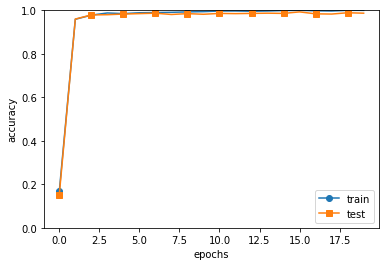

In [3]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')

* MNISTデータセットで学習すると、訓練データの認識率は%、テストデータの認識率が%となる

    * さらに層を重ねてディープにすることで、テストデータの認識率が99%を超えるネットワークを実現する

* 畳み込み層とプーリング層は画像認識では必須のモジュール
    
    * 画像という空間的な形状のある特性を、CNNはうまく読み取ることができ、手書き数字においても、高精度の認識を実現できた

| 版   | 年/月/日   |
| ---- | ---------- |
| 初版 | 2019/05/18 |